**Table of contents**

* [PCFG lib](#lib)
    * [Span](#span)
* [CKY+](#cky+)
    * [Item](#item)
    * [Agenda](#agenda)
    * [Inference rules](#inference-rules)
    * [Deduction](#deduction)
* [PCFG recap](#pcfg)
* [Inside](#inside)
    * [Semirings](#semirings)
   
   
    
**Table of Exercises**

* Theory (9 points)
    * [Exercise 7-1](#ex7-1)
    * [Exercise 7-2](#ex7-2)
    * [Exercise 7-3](#ex7-3)
    * [Exercise 7-4](#ex7-4)
    * [Exercise 7-5](#ex7-5)    
* Practicals (26 points)    
    * [Exercise 7-6](#ex7-6)
    * [Exercise 7-7](#ex7-7)
    * [Exercise 7-8](#ex7-8)
* Bonus (see below for information about points)    
    * Theory: [Exercise 7-9](#ex7-9)
    * Practical: [Exercise 7-10](#ex7-10)    


**General notes**

* In this notebook you are expected to use $\LaTeX$
* Use python3.
* Use NLTK to read annotated data.
* **Document your code**: TAs are more likely to understand the steps if you document them. If you don't, it's also difficult to give you partial points for exercises that are not completely correct.
* This document contains 2 optional exercises worth bonus points.

# <a name="lib">  PCFG lib

We are going to use the basic objects defined in the last lab

* Symbol, Terminal, and Nonterminal
* Rule, and CFG

Check the file `pcfglib.py` where you will find these definitions.


In [ ]:
from pcfglib import Symbol, Terminal, Nonterminal, Rule, CFG

## <a name="span"> Span


For convenience, we will define one more type of Symbol, this will be a Span. A Span is just a Nonterminal decorated with two integers which represent a half-open interval $(i, j]$, that is:

* start (exclusive) of phrase
* end (inclusive) of phrase

It is very easy to define such Span class by inheriting from Nonterminal. 

In [ ]:
class Span(Nonterminal):
    
    def __init__(self, nonterminal: Nonterminal, start: int, end: int):
        """
        :param nonterminal: a Nonterminal category
        :param start: start position of the phrase (exclusive)
        :param end: end position of the phrase (inclusive)
        """
        if not isinstance(nonterminal, Nonterminal):
            raise ValueError('Only a Nonterminal can make a span')
        super(Span, self).__init__('%s:%d-%d' % (nonterminal.category, start, end))
        self._base_nonterminal = nonterminal
        self._span = (start, end)
        
    @property
    def base_nonterminal(self) -> Nonterminal:
        """Returns the base nonterminal: the Nonterminal without span information"""
        return self._base_nonterminal
    
    @property
    def start(self):
        """Begin of the span (open)"""
        return self._span[0]
    
    @property
    def end(self):
        """End of the span (closed)"""
        return self._span[1]

The function definition below constructs our running example PCFG. Note that it returns both the CFG object and the cpds.

As in the previous lab a collection of cpds is stored in a dictionary such that ```cpds[lhs]``` is a dictionary mapping from rules that rewrite that LHS symbol to their probability values.

In [ ]:
from collections import defaultdict


def get_toy_pcfg():
    # Some symbols
    S = Nonterminal('S')
    
    NP = Nonterminal('NP')    
    VP = Nonterminal('VP')
    PP = Nonterminal('PP')
    
    NN = Nonterminal('NN')
    Vt = Nonterminal('Vt')    
    Vi = Nonterminal('Vi')    
    DT = Nonterminal('DT')    
    IN = Nonterminal('IN')    
    CC = Nonterminal('CC')
    
    # Grammar
    G = CFG(S)
    cpds = defaultdict(lambda: defaultdict(float))
    
    # Phrasal rules
    G.add(Rule(S, [NP, VP]))
    cpds[S][Rule(S, [NP, VP])] = 1.0
    
    G.add(Rule(NP, [DT, NN]))        
    G.add(Rule(NP, [NN]))
    G.add(Rule(NP, [NP, PP]))        
    G.add(Rule(NP, [NP, CC, NP]))
    cpds[NP][Rule(NP, [DT, NN])] = 0.4
    cpds[NP][Rule(NP, [NN])] = 0.1
    cpds[NP][Rule(NP, [NP, PP])] = 0.3
    cpds[NP][Rule(NP, [NP, CC, NP])] = 0.2
    
    G.add(Rule(VP, [Vt, NP]))    
    G.add(Rule(VP, [VP, PP]))    
    G.add(Rule(VP, [Vi]))    
    G.add(Rule(VP, [VP, CC, VP]))
    cpds[VP][Rule(VP, [Vt, NP])] = 0.3
    cpds[VP][Rule(VP, [VP, PP])] = 0.4
    cpds[VP][Rule(VP, [Vi])] = 0.2
    cpds[VP][Rule(VP, [VP, CC, VP])] = 0.1
    
    G.add(Rule(PP, [IN, NP]))    
    cpds[PP][Rule(PP, [IN, NP])] = 1.
    
    # Preterminal rules
    G.add(Rule(NN, [Terminal('dog')]))        
    G.add(Rule(NN, [Terminal('cat')]))
    G.add(Rule(NN, [Terminal('man')]))
    G.add(Rule(NN, [Terminal('telescope')]))
    
    cpds[NN][Rule(NN, [Terminal('dog')])] = 0.3
    cpds[NN][Rule(NN, [Terminal('cat')])] = 0.2
    cpds[NN][Rule(NN, [Terminal('man')])] = 0.4
    cpds[NN][Rule(NN, [Terminal('telescope')])] = 0.1
    
    G.add(Rule(DT, [Terminal('the')]))
    G.add(Rule(DT, [Terminal('a')]))
    cpds[DT][Rule(DT, [Terminal('the')])] = 0.6
    cpds[DT][Rule(DT, [Terminal('a')])] = 0.4
    
    G.add(Rule(CC, [Terminal('and')]))
    G.add(Rule(CC, [Terminal(',')]))
    cpds[CC][Rule(CC, [Terminal('and')])] = 0.8
    cpds[CC][Rule(CC, [Terminal(',')])] = 0.2
        
    G.add(Rule(IN, [Terminal('with')]))
    G.add(Rule(IN, [Terminal('through')]))
    G.add(Rule(IN, [Terminal('within')]))
    cpds[IN][Rule(IN, [Terminal('with')])] = 0.5
    cpds[IN][Rule(IN, [Terminal('through')])] = 0.3
    cpds[IN][Rule(IN, [Terminal('within')])] = 0.2

    G.add(Rule(Vt, [Terminal('saw')]))
    G.add(Rule(Vt, [Terminal('barked')]))
    G.add(Rule(Vt, [Terminal('meowed')]))
    G.add(Rule(Vt, [Terminal('moved')]))
    cpds[Vt][Rule(Vt, [Terminal('saw')])] = 0.4
    cpds[Vt][Rule(Vt, [Terminal('barked')])] = 0.3
    cpds[Vt][Rule(Vt, [Terminal('meowed')])] = 0.2
    cpds[Vt][Rule(Vt, [Terminal('moved')])] = 0.1
    
    G.add(Rule(Vi, [Terminal('barked')]))
    G.add(Rule(Vi, [Terminal('ran')]))
    G.add(Rule(Vi, [Terminal('meowed')]))
    cpds[Vi][Rule(Vi, [Terminal('barked')])] = 0.2
    cpds[Vi][Rule(Vi, [Terminal('ran')])] = 0.7
    cpds[Vi][Rule(Vi, [Terminal('meowed')])] = 0.1
    
    return G, cpds

Let's inspect our grammar

In [ ]:
G, cpds = get_toy_pcfg()
print(G)

as well as our cpds

In [ ]:
for lhs, cpd in cpds.items():
    for rule, prob in cpd.items():
        print(prob, rule)

# <a name="cky+"> CKY+ 


In this section we will implement a generalised CKY algorithm which can deal with an arbitrary epsilon-free CFG.

We will implement the parsing strategy **for you** to guarantee that it is correct. The focus of this lab is on the **inside recursion**. An extra will involve implementing a different parsing strategy, for that some of the data structures we will develop here are indeed very useful, thus take this as a learning opportunity and try to reuse some code if you decide to implement the extra.

There will be nonetheless questions throught this lab, so stay tuned.


Again we will use a deductive system to describe the parsing strategy:

\begin{align}
\text{Item} &\qquad [i, X \rightarrow \alpha_\blacksquare \, \bullet \, \beta_\square, j] \\
\text{Goal} &\qquad [1, S \rightarrow \beta_\blacksquare \, \bullet, n]  \\
\text{Axioms} &\qquad [i, X \rightarrow \bullet \alpha_\square, i] &~\text{ for all } X \rightarrow \alpha \in \mathcal R \\
\text{Scan} &\qquad \frac{[i, X \rightarrow \alpha_\blacksquare \, \bullet \, x_{j+1}  \, \beta_\square, j]}{[i, X \rightarrow \alpha_\blacksquare \, x_{j+1} \bullet \, \beta_\square, j + 1]} \\
\text{Complete} &\qquad \frac{[i, X \rightarrow \alpha_\blacksquare \, \bullet \, Y \, \beta_\square ,k] [k, Y \rightarrow \gamma_\blacksquare \, \bullet , j]}{[i,  X \rightarrow \alpha_\blacksquare \, Y_{k,j} \, \bullet \, \beta_\square , j]}
\end{align}




<a name="ex7-1" style="color:red">**Exercise 7-1**</a> **[1 point]** Explain the meaning of an item (make sure to discuss all elements in it).

<a name="ex7-2" style="color:red">**Exercise 7-2**</a> **[1 point]** Explain the goal of the program


<a name="ex7-3" style="color:red">**Exercise 7-3**</a> **[1 point]** Explain the axioms of the program



<a name="ex7-4" style="color:red">**Exercise 7-4**</a> **[1 point]** Explain SCAN (make sure to discuss all elements of the rule)



<a name="ex7-5" style="color:red">**Exercise 7-5**</a> **[1 point]** Explain the COMPLETE rule including all of its elements including the side condition.

The actual **deduction** is nothing but an exhaustive enumeration of valid items.
* we start from axioms
* and proceed by either scanning or completing previously derived items
* each such operation creates additional items
* if these items were not yet discovered, they make it to what we call an **agenda**
* the agenda is much like a queue of items yet to be processed
* processing an item means simply giving it the chance to participate in scan and complete
* we should be careful to never process an item twice under the same premises 
* items that are yet to be processed are called **active items**
* items already processed are called **passive items**
* at the end there should be no active item and many passive items
* parsing is possible if we derive/prove/reach the goal item
* the complete items in the passive set can be used to derive a **parse forest**
* a parse forest is much like a CFG but its rules have symbols which are decorated with spans indicating how they parse the input sentence
* we can use parse forests to answer questions such as: what trees can parse the sentence? And when we introduce PCFGs, we will be able to answer quetions such as: what's the best tree that parses the sentence? what's the total probability value of the sentence (once we marginalise all possible parse trees).

Now we turn to implementation, which will require a few classes and data structures, but we will discuss them one by one.

## <a name="item"> Item

We have to start by turning items into code!

We are using dotted rules to represent items in CKY+. A dotted rule is basically a container for 
* a context-free production
* a list of positions already covered in the input sentence
    * together this represents the start and end position as well as the black squares in the item
    
    
This is an item formally

\begin{align}
\qquad [i, X \rightarrow \alpha_\blacksquare \, \bullet \, \beta_\square, j]
\end{align}
    
and this is how we realise it in our implementation

        [LHS -> RHS, [i...j]]

the first element of the pair is the rule `LHS -> RHS` and the second is a list of positions where the dot has been.


In [ ]:
class Item:    
    """
    A dotted rule used in CKY
    
    We store a rule and a list of positions (which we call `dots` because they indicate 
     positions where the dots have been)
    
    We make an Item a hashable object so that we can use it in dictionaries.
    
    """
    
    def __init__(self, rule: Rule, dots: list):
        if len(dots) == 0:
            raise ValueError('I do not accept an empty list of dots')
        self._rule = rule
        self._dots = tuple(dots)
        
    def __eq__(self, other: 'Item'):
        """Two items are identical if they contain the same rule and cover the same positions"""
        return self._rule == other._rule and self._dots == other._dots
        
    def __hash__(self):
        """We let python hash the two objects that represent an Item"""
        return hash((self._rule, self._dots))
    
    def __str__(self):
        return '[{0}, {1}]'.format(self._rule, self._dots)
    
    def __repr__(self):
        return str(self)
    
    @property
    def lhs(self):
        return self._rule.lhs
    
    @property
    def rule(self):
        return self._rule
    
    @property
    def dot(self):
        return self._dots[-1]
    
    @property
    def start(self):
        return self._dots[0]
    
    @property
    def next(self):
        """return the symbol to the right of the dot (or None, if the item is complete)"""
        if self.is_complete():
            return None
        return self._rule.rhs[len(self._dots) - 1]
    
    def state(self, i):
        return self._dots[i]

    def advance(self, dot):
        """return a new item with an extended sequence of dots"""
        return Item(self._rule, self._dots + (dot,))
    
    def is_complete(self):
        """complete items are those whose dot reached the end of the RHS sequence"""
        return len(self._rule.rhs) + 1 == len(self._dots)    
    

Let's play a bit with item objects to see how they work

In [ ]:
r = Rule(Nonterminal('S'), [Nonterminal('X')])
i1 = Item(r, [0])
i2 = i1.advance(1)

In [ ]:
print(i1)
print(i2)

In [ ]:
i1 != i2

In [ ]:
i1.is_complete()


In [ ]:
i2.is_complete()

In [ ]:
i1.next

In [ ]:
i2.next

## <a name="agenda"> Agenda

Next we need an agenda of items. In CKY+ we have to track quite a bit of information, so we will design a more complex agenda. Because there will be a lot of functionality, we will use a class. 

In an agenda, some items are active, others are passive.

Functionally, the active agenda is nothing but a stack or queue, whereas the passive agenda is simply a set (all items that have already been processed). However, to make our inferences run faster, we can further organise the passive items for easy/quick access within inference rules.

In [ ]:
from collections import deque, defaultdict

class Agenda:
    """
    An Agenda for CKY+.
    
    The agenda will organise a queue of active items as well as a set of passive items.
    
    This agenda is such that it does not push an item twice into the queue 
        that is equivalent to saying that the agenda is capable of maintaining a set of already discovered items.
        
    This agenda will also organise the passive items for quick access in the COMPLETE rule. 
        This means we will store complete and incomplete items separately and hash them by some useful criterion.
        A complete item essentially contributes to further advancing incomplete items. 
        Incomplete items need to be further completed.
    """
    
    def __init__(self):
        # we are organising active items in a stack (last in first out)
        self._active = deque([])
        # an item should never queue twice, thus we will manage a set of items which we have already seen
        self._discovered = set()

        # Passive items may be complete
        #   in which case they help us complete other items
        #  and they may be incomplete
        #   in which case we will be trying to complete them
        # In order to make COMPLETE inferences easier, we will separate passive items into these two groups
        #  and we will also organise each group conveniently.
        
        # We organise incomplete items by the symbols they wait for at a certain position
        #  that is, if the key is a pair (Y, i)
        #  the value is a set of items of the form
        #    [X -> alpha * Y beta, [...i]]
        #  in other words "items waiting for a Y to project a span from i"
        self._incomplete = defaultdict(set)  
        
        # We organise complete items by their LHS symbol spanning from a certain position
        #  if the key is a pair (X, i)
        #  then the value is a set of items of the form
        #   [X -> gamma *, [i ... j]]
        self._complete = defaultdict(set)
        
    def __len__(self):
        """return the number of active items"""
        return len(self._active)
        
    def push(self, item: Item):
        """push an item into the queue of active items"""
        if item not in self._discovered:  # if an item has been seen before, we simply ignore it
            self._active.append(item)
            self._discovered.add(item)
            return True
        return False
    
    def pop(self):
        """pop an active item"""
        if len(self._active) == 0:
            raise ValueError('I have no items left')
        return self._active.pop()
    
    def make_passive(self, item: Item):
        if item.is_complete():  # complete items offer a way to rewrite a certain LHS from a certain position
            self._complete[(item.lhs, item.start)].add(item)
        else:  # incomplete items are waiting for the completion of the symbol to the right of the dot
            self._incomplete[(item.next, item.dot)].add(item)
            
    def waiting(self, symbol: Symbol, dot: int):
        return self._incomplete.get((symbol, dot), set())
    
    def complete(self, lhs: Nonterminal, start: int):
        return self._complete.get((lhs, start), set())
    
    def itercomplete(self):
        """an iterator over complete items in arbitrary order"""
        for items in self._complete.values():
            for item in items:
                yield item
                

Let's see how this works

In [ ]:
A = Agenda()

In [ ]:
r1 = Rule(Nonterminal('S'), [Nonterminal('S'), Nonterminal('X')])
r1

we can push items into the agenda

In [ ]:
A.push(Item(r1, [0]))  # S -> S X, [0]  (earley axiom)

and the agenda will make sure there are no duplicates

In [ ]:
A.push(Item(r1, [0]))

In [ ]:
len(A)

In [ ]:
i1 = Item(r1, [0])
i1

In [ ]:
A.make_passive(i1)

In [ ]:
A.push(Item(Rule(Nonterminal('S'), [Nonterminal('X')]), [0]))

In [ ]:
A.make_passive(Item(Rule(Nonterminal('S'), [Nonterminal('X')]), [0]))

In [ ]:
A.push(Item(Rule(Nonterminal('S'), [Nonterminal('X')]), [0, 1]))

In [ ]:
A.make_passive(Item(Rule(Nonterminal('S'), [Nonterminal('X')]), [0, 1]))

In [ ]:
list(A.itercomplete())

## <a name="inference-rules"> Inference rules

### Basic axioms

For every rule X -> alpha, and every input position (i) between 0 and n-1, we have an item of the kind:

\begin{equation}
[i, X \rightarrow \bullet \alpha_\square, i]
\end{equation}

In our implementation an axiom looks like this

         [X -> alpha, [i]]

In [ ]:
def axioms(cfg: CFG, sentence: list):
    """
    :params cfg: a context-free grammar (an instance of WCFG)
    :params sentence: the input sentence (as a list or tuple)
    :returns: a list of items
    """
    items = []
    for rule in cfg:
        for i, x in enumerate(sentence): 
            # We will implement a tiny optimisation here
            
            # For rules that start with terminals we can use "look ahead"
            if isinstance(rule.rhs[0], Terminal):  
                # this is a mechanism by which we avoid constructing items which we know cannot be scanned
                #  that's the terminal that starts the rule does not occur in the sentence we are parsing
                if rule.rhs[0] == x:
                    items.append(Item(rule, [i]))
            else:
                items.append(Item(rule, [i]))
    return items

Let's have a look what type of axioms we get, note that CKY+ is very greedy. Earley parsing is an alternative strategy that's far more conservative than CKY+, for example, Earley avoids instantiating items that are not yet required and instead uses a simpler axiom (you will seee it later).

In [ ]:
sentence = [Terminal(w) for w in 'the man saw the dog with a telescope'.split()]
axioms(G, sentence)

## Scan

If the dot is placed at a position just before a *terminal*,  we can **scan** it provided that the terminal matches the corresponding input position.


\begin{equation}
    \frac{[i, A \rightarrow \alpha_\blacksquare \, \bullet \, x_{j+1}  \, \beta_\square, j]}{[i, A \rightarrow \alpha_\blacksquare \, x_{j+1} \bullet \, \beta_\square, j + 1]}
\end{equation}

In our implementation with dot lists it looks like this

               [X -> alpha * x beta, [i ... j]] 
         --------------------------------------------
          [X -> alpha x * beta, [i ... j] + [j + 1]]
          

note that the `*` is simply indicating where the last dot would be.

In [ ]:
def scan(item: Item, sentence):
    if isinstance(item.next, Terminal):
        if item.dot < len(sentence) and sentence[item.dot] == item.next:
            return item.advance(item.dot + 1)
    else:
        return None

In [ ]:
scanned = []
for item in axioms(G, sentence):
    new = scan(item, sentence)
    if new is not None:
        scanned.append(new)
scanned

## Complete

Here we let an active item interact with passive items:

* either an active item is complete, then we try to advance incomplete passive items

* or an active item is incomplete, in which case we try to advance the item itself by looking back to complete passive items

Both cases are covered by the inference rule

\begin{align}
\qquad \frac{[i, X \rightarrow \alpha_\blacksquare \, \bullet \, Y \, \beta_\square ,k] [k, Y \rightarrow \gamma_\blacksquare \, \bullet , j]}{[i,  X \rightarrow \alpha_\blacksquare \, Y_{k,j} \, \bullet \, \beta_\square , j]}
\end{align}

In our implementation with dot lists it looks like this

         [X -> alpha * Y beta, [i ... k]] [Y -> gamma *, [k ... j]]
         ----------------------------------------------------------
                 [X -> alpha Y * beta, [i ... k] + [j]]


In [ ]:
def complete(item: Item, agenda: Agenda):
    items = []
    # This has two cases
    # either the input item corresponds to the second antecedent in the COMPLETE inference rule
    #  in which case the item is complete (the dot stands at the end)
    # or the input item corresponds to the first antecedent in the COMPLETE inference rule
    #  in which case the item is itself incomplete
    
    # When it is *complete* we use it to advance incomplete ones.
    # When it is *incomplete* we check if we know a complete item that can advance it.
    
    # First we deal with the complete case
    if item.is_complete():  # If the item is complete, it can be used to advance incomplete items
        # We then look for incomplete items that are waiting for 
        #  the LHS nonterminal of our complete item 
        #  in particular, if it matches the start position of our complete item
        for incomplete in agenda.waiting(item.lhs, item.start):
            items.append(incomplete.advance(item.dot))
    else:  # Then we deal with the incomplete case
        # look for completions of item.next spanning from item.dot
        ends = set()
        for complete in agenda.complete(item.next, item.dot):
            ends.add(complete.dot)
        # advance the dot of the input item for each position that completes a span
        for end in ends:
            items.append(item.advance(end))
    return items

## Forest from complete items

Each **complete** item in the (passive) agenda can be mapped to a new CFG rule (with nonterminal symbols annotated with spans).
For example, an item such as

        [X -> A x B *, [0,1,2,3]]
        
results in the rule

        X:0-3 -> A:0-1 x B:2-3
        
observe how only nonterminal nodes get annotated: this helps us keep terminals and nonterminals clearly separate.

In [ ]:
def make_span(sym: Symbol, start: int, end: int):
    """
    Helper function that returns a Span for a certain symbol.
    
    This function will only make spans out of nonterminals, terminals are return as is.
    :param sym: Terminal or Nonterminal symbol
    :param start: open begin
    :param end: closed end
    :returns: Span(sym, start, end) or sym (if Terminal)
    """
    if isinstance(sym, Nonterminal):
        return Span(sym, start, end)
    else:
        return sym

Making a forest is indeed really simple, we just need to return a new CFG with rules derived from complete items in the passive set. The rules will have their nonterminals annotated into spans.

In [ ]:
def make_forest(complete_items: list, forest_start: Nonterminal):
    """
    Converts complete items from CKY+ into a forest, that is, a CFG whose rules have spans for nonterminals.
    
    :param complete_items: a collection of dotted items which are complete (dot at the end of the RHS)
    :param forest_start: the start nonterminal (a Span) of the forest
    """
    if not isinstance(forest_start, Span):
        raise ValueError('The start symbol of a forest should be a span')
    forest = CFG(forest_start)
    for item in complete_items:    
        lhs = make_span(item.lhs, item.start, item.dot)
        rhs = []
        for i, sym in enumerate(item.rule.rhs):
            if isinstance(sym, Terminal):
                rhs.append(sym)
            else:
                rhs.append(make_span(sym, item.state(i), item.state(i + 1)))
        forest.add(Rule(lhs, rhs))        
    return forest

## <a name="deduction"> Deduction

Start with axioms and exhaustively apply inference rules

In [ ]:
def cky(cfg: CFG, sentence):
    A = Agenda()
    for item in axioms(cfg, sentence):
        A.push(item)
    while A:
        item = A.pop()
        # a complete item can be used to complete other items
        # alternatively, we may be able to advance an incomplete item
        #  whose next symbol is a nonterminal by combining it with some passive complete item 
        if item.is_complete() or isinstance(item.next, Nonterminal):
            for new in complete(item, A):
                A.push(new)
        else:  # here we have a terminal ahead of the dot, thus only scan is possible
            new = scan(item, sentence)
            if new is not None:  # if we managed to scan                
                A.push(new)
        A.make_passive(item)
    forest_start = make_span(cfg.start, 0, len(sentence))
    forest = make_forest(A.itercomplete(), forest_start)    
    if forest.can_rewrite(forest_start):
        return forest
    else:
        return CFG(forest_start)

In [ ]:
forest = cky(G, sentence)

In [ ]:
forest.start

In [ ]:
forest.can_rewrite(forest.start)

In [ ]:
print(forest)

Note that if we modify the sentence in a way that it can't be parsed by G we will get an empty forest

In [ ]:
empty_forest = cky(G, sentence + [Terminal('!')])

In [ ]:
empty_forest.start

In [ ]:
empty_forest.can_rewrite(empty_forest.start)

#  <a name="pcfg"> PCFG recap

A probabilistic CFG is a simple extension to CFGs where we assign a joint probability distribution over the space of context-free *derivations*. 

A random **derivation** $D = \langle R_1, \ldots, R_m \rangle$ is a sequence of $m$ *random rule applications*.
A random rule is a pair of a random LHS nonterminal $V$ and a random RHS sequence $\beta$, where $V \rightarrow \beta$ corresponds to a valid rule in the grammar.

We assume that a derivation is generated one rule at a time and each rule is generated independently. Moreover, the probability value of a rule is given by a conditional probability distribution over RHS sequences given LHS nonterminal. 


\begin{align}
P_{D|M}(r_1^m|m) &= \prod_{i=1}^m P_R(r_i) \\
 &= \prod_{i=1}^m P_{\text{RHS}|\text{LHS}}(\beta_i | v_i)\\
 &= \prod_{i=1}^m \text{Cat}(\beta_i | \boldsymbol \theta^{v_i})\\
 &= \prod_{i=1}^m \theta_{v_i \rightarrow \beta_i}\\
\end{align}

We can implement PCFGs rather easily by pairing a CFG grammar with a dictionary mapping from rules to their probabilities. But we must remember that for each given LHS symbol, the probability values of all of its rewriting rules must sum to 1.

\begin{equation}
\sum_{\beta} \theta_{v \rightarrow \beta} = 1
\end{equation}


#  <a name="inside"> Inside algorithm


This is the core of this lab, the inside recursion. The inside recursion (also known as **value recursion**) is incredibly general, it can be used to compute a range of interesting quantities.

The formula below corresponds to the recursion:

\begin{align}
(1)\qquad    I(v) &= 
    \begin{cases}
        \bar{1} & \text{if }v \text{ is terminal and } \text{BS}(v) = \emptyset\\
        \bar{0} & \text{if }v \text{ is nonterminal and } \text{BS}(v) = \emptyset \\
        \displaystyle\bigoplus_{\frac{a_1 \ldots a_n}{v: \theta} \in \text{BS}(v)} \theta \otimes \bigotimes_{i=1}^n I(a_i) & \text{otherwise}
    \end{cases}
\end{align}

In this formula $\text{BS}(v)$ is the *backward-star* of the node, or the set of edges **incoming** to the node. That is, all edges (rules with spans) that have that node as an LHS symbol. There is one detail important to remember. In principle only *terminal* nodes would have an empty backward-star. But because our parsing strategy can produce some dead-end nodes (nodes that cannot be expanded) we will have some nonterminal nodes with empty backward-star. Those are special cases, which we treat specially. Essentially, we give them an inside value of $\bar 0$.

## <a name="semirings">  Semirings

In this formula we use generalised sum $\oplus$ and generalised product $\otimes$ which we explain below.

A **semiring** is algebraic structure $\langle \mathbb K, \oplus, \otimes, \bar 0, \bar 1\rangle$ which corresponds to a set $\mathbb K$ equipped with addition $\oplus$ and multiplication $\otimes$.

### Real semiring

For example, the algebra you learnt at school is a semiring! 
The set of interest is the real line $\mathbb K = \mathbb R$.

Then if we have two real numbers, $a \in \mathbb R$ and $b \in \mathbb R$, we define **sum** as
\begin{equation}
a \oplus b = a + b
\end{equation}
which is simply the standard addition.
The additive identity is the value in the set that does not affect summation, we indicate it by $\bar 0$. In this case, we are talking about the real number 0:
\begin{equation}
a \oplus \bar 0 = a + 0 = a
\end{equation}

We can also define **multiplication**
\begin{equation}
a \otimes b = a \times b
\end{equation}
which is simply the standard multiplication.
The multiplicative identity is the value in the set that does not affect multiplication, we indicate it by $\bar 1$. In this case, we are talking about the read number 1:
\begin{equation}
a \otimes \bar 1 = a \times 1 = a
\end{equation}

### Log-Probability semiring

When we compute a log-marginal, we are essentially using a logarithmic semiring. 

Then the set of interest is the set of log-probability values. Probabilities range between $0$ and $1$ and therefore log-probabilities range from $-\infty$ (which is $\log 0$) to $0$ (which is $\log 1$). We denote this set $\mathbb K = \mathbb R_{\le 0} \cup \{-\infty\}$.

Then if we have two log-probability values $a \in \mathbb K$ and $b \in \mathbb K$, our sum becomes
\begin{equation}
a \oplus b = \log(\exp a + \exp b)
\end{equation}
Here we first exponentiate the values bringing them back to the real semiring (where we know how to sum), then we use the standard sum (from high school), and convert the result back to the log-probability semiring by applying $\log$ to the result.

Our product becomes
\begin{equation}
a \otimes b = a + b
\end{equation}
which exploits a basic property of logarithms.


Our additive identity is
\begin{equation}
a \oplus \bar 0 = \log (\exp a + \underbrace{\exp(-\infty)}_{0}) = \log \exp a = a
\end{equation}
this is the case because exponentiating an infinitely negative number converges to $0$.

Finally, our multiplicative identity is
\begin{equation}
a \otimes \bar 1 = a \times 1 = a
\end{equation}


The interesting thing about semirings is that they manipulate different *types of numbers* but they are coherent with the basic axioms of math that we are used to. They help us realise that several algorithms are actually all the same, but they happen to operate under different algebraic structures (read: different definitions of what sum and multiplication are).

We will define a general class for semirings and you will implement various specialisations. 
This class will only contain **class methods** this makes the class more or less like a package that can be used to organise coherent functions without really storing any content.

In [ ]:
class Semiring:
    """
    This is the interface for semirings.
    """
    
    @classmethod
    def from_real(cls, a: float):
        """This method takes a number in the Real semiring and converts it to the semiring of interest"""
        raise NotImplementedError('You need to implement this in the child class')
        
    @classmethod
    def to_real(cls, a: float):
        """This method takes a number in this semiring and converts it to the Real semiring"""
        raise NotImplementedError('You need to implement this in the child class')
    
    @classmethod
    def one(cls):
        """This method returns the multiplicative identity of the semiring"""
        raise NotImplementedError('You need to implement this in the child class')
    
    @classmethod
    def zero(cls):
        """This method returns the additive identity of the semiring"""
        raise NotImplementedError('You need to implement this in the child class')
    
    @classmethod
    def plus(cls, a, b):
        """
        This method sums a and b (in the semiring sense)
            where a and b are elements already converted to the type of numbers manipulated by the semiring
        """
        raise NotImplementedError('You need to implement this in the child class')
    
    @classmethod
    def times(cls, a, b):
        """
        This method multiplies a and b (in the semiring sense)
            where a and b are elements already converted to the type of numbers manipulated by the semiring
        """
        raise NotImplementedError('You need to implement this in the child class')

We will implement for you the *Marginal semiring*, that is, the basic algebra from school.

In [ ]:
class MarginalSemiring(Semiring):
    
    @classmethod
    def from_real(cls, a: float):
        return a
    
    @classmethod
    def to_real(cls, a: float):
        return a
    
    @classmethod
    def one(cls):
        return 1.
    
    @classmethod
    def zero(cls):
        return 0.
    
    @classmethod
    def plus(cls, a, b):
        return a + b
    
    @classmethod
    def times(cls, a, b):
        return a * b

In [ ]:
MarginalSemiring.from_real(0.2)

In [ ]:
MarginalSemiring.to_real(0.5)

In [ ]:
MarginalSemiring.plus(0.1, 0.2)

In [ ]:
MarginalSemiring.times(0.2, 0.3)

In [ ]:
MarginalSemiring.one()

In [ ]:
MarginalSemiring.zero()

and we also implement for you the *ViterbiSemiring* used to compute maximum probabilities.

In [ ]:
import numpy as np
class ViterbiSemiring(Semiring):
    
    @classmethod
    def from_real(cls, a: float):
        return a
    
    @classmethod
    def to_real(cls, a: float):
        return a
    
    @classmethod
    def one(cls):
        return 1.
    
    @classmethod
    def zero(cls):
        return 0.
    
    @classmethod
    def plus(cls, a, b):
        return np.maximum(a, b)
    
    @classmethod
    def times(cls, a, b):
        return a * b

In [ ]:
ViterbiSemiring.times(0.2, 0.3)

note how the following will pick the maximum rather than accumulate the numbers

In [ ]:
ViterbiSemiring.plus(0.1, 0.4)

Now you implement the $\log$ variants of both semirings:


<a name="ex7-6" style="color:red">**Exercise 7-6**</a> **[6 points]** Implement LogMarginalSemiring below as a log-variant of the MarginalSemiring as well as LogViterbiSemiring as a log-variant of the ViterbiSemiring. Run examples of all methods and confirm that the quantities they compute correspond to the correct quantities when converted back to the Real semiring using `to_real`.

* **[3 points]** LogMarginalSemiring
* **[3 points]** LogViterbiSemiring

In [ ]:
class LogMarginalSemiring(Semiring):
    
    # TYPE YOUR SOLUTION
    pass

In [ ]:
class LogViterbiSemiring(Semiring):
    
    # TYPE YOUR SOLUTION
    pass

## Implementing the inside recursion

For the inside recursion you need the weight (parameter converted to the appropriate semiring) of the rule that justifies each edge. 

For that we provide you with a helper function. It receives an edge (Rule with spans) and the cpds of the original grammar and returns the correct parameter.

In [ ]:
from typing import Dict

def get_parameter(edge: Rule, cpds: Dict[Nonterminal, Dict[Rule, float]]):
    base_rhs = [node.base_nonterminal if isinstance(node, Span) else node for node in edge.rhs]
    base_rule = Rule(edge.lhs.base_nonterminal, base_rhs)
    return cpds[base_rule.lhs][base_rule]

In [ ]:
# Now if you ever need to get the parameter for a rule in the grammar you can use the function above
# For example, 
for edge in forest:
    print(get_parameter(edge, cpds), edge)

<a name="ex7-7" style="color:red">**Exercise 7-7**</a> **[15 points]** Now you should implement the inside recursion below

* see below for example of inside values for a correct implementation

In [ ]:
def compute_inside_table(forest: CFG, cpds: Dict[Nonterminal, Dict[Rule, float]], semiring: Semiring):
    """
    Computes the inside table, that is, the table that assigns an inside value to each 
        node in the forest, where a node is a Span.
        
        For convenience, this table may also contain inside values for nodes that are not spans, such as the leaves
            or terminals of the forest, but then that inside should be semiring.one()
            
        Our parsing strategies sometimes create useless nodes, these are nonterminal nodes that have no way
            of being expanded (there are no edges incoming to those nodes, they have an empty backward-star).
            We consider those nodes have an inside value of semiring.zero().
            This is necessary to circumvent the fact that the parsing strategy can create such useless items.
    
    :param forest: a forest as produced by CKY+
    :param cpds: the cpds of the original grammar
    :param semiring: a choice of Semiring
    :return: inside table as a dictionary from a Span to an inside value (as a number in the semiring)
    """
    pass

Marginal probability is the inside of the GOAL item in the LogMarginalSemiring (converted back to a real number) .

Here is what your result should look like

```python
inside_table = compute_inside_table(forest, cpds, LogMarginalSemiring)
LogMarginalSemiring.to_real(inside_table[forest.start])
4.6448640000000001e-06
```

In [ ]:
LogMarginalSemiring.to_real(inside_table[forest.start])

Maximum probability is the inside of the GOAL item in the LogViterbiSemiring (converted back to a real number) .

Here is what your result should look like

```python
viterbi_table = compute_inside_table(forest, cpds, LogViterbiSemiring)
LogViterbiSemiring.to_real(viterbi_table[forest.start])
2.6542080000000048e-06

```

In [ ]:
viterbi_table = compute_inside_table(forest, cpds, LogViterbiSemiring)

In [ ]:
LogViterbiSemiring.to_real(viterbi_table[forest.start])

We can even define a semiring to count! Imagine that a semiring maps from the real numbers by saying that if something has non-zero probability it counts as $1$ and if it has zero probability it counts as $0$.

In [ ]:
class CountSemiring(Semiring):
    
    @classmethod
    def from_real(cls, a: float):
        """Map to 1 if a bigger than 0"""
        return 1. if a > 0. else 0.
    
    @classmethod
    def to_real(cls, a: float):
        return a
    
    @classmethod
    def one(cls):
        return 1.
    
    @classmethod
    def zero(cls):
        return 0.
    
    @classmethod
    def plus(cls, a, b):
        return a + b
    
    @classmethod
    def times(cls, a, b):
        return a * b

Then we can use the inside algorithm to find the number of **derivations** in the parse forest! 

If your inside implementation is corret, this is what your result should look like:

```python
count_table = compute_inside_table(forest, cpds, CountSemiring)
CountSemiring.to_real(count_table[forest.start])
2.0
```

In [ ]:
count_table = compute_inside_table(forest, cpds, CountSemiring)

In [ ]:
CountSemiring.to_real(count_table[forest.start])

Isn't this great? :D

Now you are ready to compute the actual Viterbi derivation!

## Viterbi derivation

The Viterbi path is a top-down traversal of the forest, where each time we have to choose which rule/edge to use to expand a certain nonterminal symbol (span node), we choose the one whose inside value is maximum. But recall that the inside value associated with an *edge* must take into account the weight of the edge and the inside value of its children. Of course, all of this must happen within a maximising semiring (e.g. LogViterbiSemiring or ViterbiSemiring). 


\begin{align} 
(2) \qquad e^\star &= \arg\!\max_{e \in \text{BS(v)}} \theta \otimes \bigotimes_{i=1}^n I(a_i) \\
    &~\text{where }e:=\frac{a_1, \ldots, a_n}{v}:\theta
\end{align}



<a name="ex7-8" style="color:red">**Exercise 7-8**</a> **[5 points]** Implement a function that returns the Viterbi derivation (a sequence of rule applications that attains maximum probability).

In [ ]:
def viterbi_derivation(forest: CFG, cpds: Dict[Nonterminal, Dict[Rule, float]], inside_table: Dict[Symbol, float], semiring: Semiring):
    """
    Return the derivation (and its yield) that attains maximum probability.
    
    This is a top-down traversal from the root, where for each node v that we need to expand, we 
        solve equation (2) above.
    
    :param forest: a forest
    :param cpds: cpds of the original grammar
    :param inside_table: inside values produced with a certain maximising semiring
    :param semiring: a maximising semiring e.g. ViterbiSemiring or LogViterbiSemiring
    :returns: a tuple
        - first element is an ordered list of rule applications
        - second element is the yield of the derivation 
    """   
    pass

If your implementation is correct you should get

```python
viterbi_derivation(forest, cpds, viterbi_table, LogViterbiSemiring)
(([S:0-8] -> [NP:0-2] [VP:2-8],
  [NP:0-2] -> [DT:0-1] [NN:1-2],
  [DT:0-1] -> 'the',
  [NN:1-2] -> 'man',
  [VP:2-8] -> [VP:2-5] [PP:5-8],
  [VP:2-5] -> [Vt:2-3] [NP:3-5],
  [Vt:2-3] -> 'saw',
  [NP:3-5] -> [DT:3-4] [NN:4-5],
  [DT:3-4] -> 'the',
  [NN:4-5] -> 'dog',
  [PP:5-8] -> [IN:5-6] [NP:6-8],
  [IN:5-6] -> 'with',
  [NP:6-8] -> [DT:6-7] [NN:7-8],
  [DT:6-7] -> 'a',
  [NN:7-8] -> 'telescope'),
 ('the', 'man', 'saw', 'the', 'dog', 'with', 'a', 'telescope'))
```

You can draw trees using NLTK, here is an example, you can adjust this to visualise trees predicted by your own Viterbi derivation algorithm.

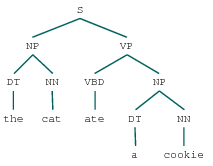

In [66]:
from nltk.tree import Tree
parse_sent = '(S (NP (DT the) (NN cat)) (VP (VBD ate) (NP (DT a) (NN cookie))))'
t = Tree.fromstring(parse_sent)
t

# Earley parsing


Earley parser is a more conservative, top-down parser, it typically enumerates far less items than CKY+. 
Answer the questions below (not optional) and as an optional extra contribute an implementation of Earley parser (you may reuse data structures developed for CKY+).

Mostly it requires a change of *axioms* and one additional inference rule (i.e. PREDICT). Tip: be careful not to predict the same item multiple times ;)

\begin{align}
\text{Item} &\qquad [i, X \rightarrow \alpha_\blacksquare \, \bullet \, \beta_\square, j] \\
\text{Goal} &\qquad [1, S \rightarrow \beta_\blacksquare \, \bullet, n]  \\
\text{Axioms} &\qquad [0, S \rightarrow \bullet \alpha_\square, 0] &~\text{ for all } S \rightarrow \alpha \in \mathcal R \\
\text{Scan} &\qquad \frac{[i, X \rightarrow \alpha_\blacksquare \, \bullet \, x_{j+1}  \, \beta_\square, j]}{[i, X \rightarrow \alpha_\blacksquare \, x_{j+1} \bullet \, \beta_\square, j + 1]} \\
\text{Predict} &\qquad \frac{[i, X \rightarrow \alpha_\blacksquare \, \bullet \, Y_{j+1}  \, \beta_\square, j]}{[j, Y \rightarrow \gamma_\square, j]} &~\text{for all } Y \rightarrow \gamma \in \mathcal R\\
\text{Complete} &\qquad \frac{[i, X \rightarrow \alpha_\blacksquare \, \bullet \, Y \, \beta_\square ,k] [k, Y \rightarrow \gamma_\blacksquare \, \bullet , j]}{[i,  X \rightarrow \alpha_\blacksquare \, Y_{k,j} \, \bullet \, \beta_\square , j]}
\end{align}



<a name="ex7-9" style="color:red">**Exercise 7-9**</a> ***THIS IS EXERCISE IS OPTIONAL, ITS POINTS COUNT AS BONUS*** 

* **[0.25 points]** Axioms
* **[0.25 points]** Scan
* **[0.25 points]** Predict
* **[0.25 points]** Complete


* Points: this exercise is worth 1 extra absolut point added directly to your final grade for *theory*. Recall that *theory* accounts at most for 20% of your grade, thus we first compute your grade without bonuses, then we add the points you earn here. The resulting grade however can never exceed 2 points (that is, 20% of the maximum possible final grade).
* Note: we will grade this exercise using the scale: 0, 1/4, 1/2, 3/4, 1.

<a name="ex7-10" style="color:red">**Exercise 7-10**</a> ***THIS IS EXERCISE IS OPTIONAL, ITS POINTS COUNT AS BONUS*** 


Implement Earley parser and show that it works by parsing the running example and showing the inside value of the GOAL item for LogMarginalSemiring, LogViterbiSemiring, and CountSemiring.


* Points: this exercise is worth 1 extra absolut point added directly to your final grade for *practicals*. Recall that *practicals* account at most for 40% of your grade, thus we first compute your grade without bonuses, then we add the points you earn here. The resulting grade however can never exceed 4 points (that is, 40% of the maximum possible final grade).
* Note: we will grade this exercise using the scale: 0, 1/4, 1/2, 3/4, 1.

